In [2]:
# Created Jan 9, 2022
# Updated Jan 9, 2022

import sys
sys.path.append('../')

import sys; sys.path.insert(0, '../../') ## make sure path to root of project directory
from wu_barcodes.config import *
from data.wu_data import *

import matplotlib as mpl
import matplotlib.pyplot as plt
import methods.ax_methods as ax_methods
mpl.rcParams.update(mpl_configs)
import numpy as np; rnd = np.random.default_rng()
import scipy.stats

blues = mpl.cm.get_cmap('Blues')
reds = mpl.cm.get_cmap('Reds')
#
# from methods.rank_order_methods import *

diet_colors = {'HF':'red', 'LF':'blue', 'HLH':'orange', 'LHL':'purple'}

if 'load data':
    with open(f'{data_dir}2/bac_lineage_positions.pkl', 'rb') as f:
        bac_lineage_positions = pickle.load(f)

    with open(f'{data_dir}2/bac_row_ids.pkl', 'rb') as f:
        bac_row_ids = pickle.load(f)

    with open(f'{data_dir}2/bac_read_arrays.pkl', 'rb') as f:
        bac_read_arrays = pickle.load(f)

    with open(f'{data_dir}2/bac_input_arrays.pkl', 'rb') as f:
        bac_input_arrays = pickle.load(f)

    with open(f'{data_dir}2/gene_meta_dict.pkl', 'rb') as f:
        bac_gene_meta_dict = pickle.load(f)

    with open(f'{data_dir}2/lineage_gene_map.pkl', 'rb') as f:
        bac_lineage_gene_map = pickle.load(f)

    with open(f'{data_dir}2/nonwu_indices.pkl', 'rb') as f:
        bac_nonwu_indices = pickle.load(f)

In [3]:
import methods.filter_lineages as fl

import scipy.ndimage.filters as ndif
def running_mean_uniform_filter1d(x, N):
    return ndif.uniform_filter1d(x, N, mode='reflect', origin=0)

def heat_map(ax, bac, m1, m2, day, day0_read_range):
    print('*** Plotting joint distribution of reads ***')
    row_ids = fl.bac_row_ids[bac]
    notWu = fl.bac_nonwu_indices[bac]
    read_array = fl.bac_read_arrays[bac][:, notWu]

    d0_reads = read_array[0]

    m1_reads = np.copy( read_array[ row_ids[(m1, day)] ] )
    m2_reads = np.copy( read_array[ row_ids[(m2, day)] ] )

    print(f'Seq. Depths of Mice={(m1_reads.sum(), m2_reads.sum())}')

    day0_min, day0_max = day0_read_range
    lineage_indices = (d0_reads >= day0_min) * (d0_reads < day0_max) #* (m1_d4_reads > 0) * (m2_d4_reads > 0)
    print(f'# lineages={lineage_indices.sum()}')

    ## plot empirical
    binspace = np.linspace(0, 80, 81)
    ax.hist2d(m1_reads[lineage_indices], m2_reads[lineage_indices], bins=binspace, norm=mpl.colors.LogNorm(0.1, 100), cmap=mpl.cm.Oranges)
    r, pval = scipy.stats.pearsonr(m1_reads[lineage_indices], m2_reads[lineage_indices])
    print(f'r, pval = {r:.2f}, {pval:.1e}')

    ax.set_xlabel('mouse {} day 4 reads'.format(m1))
    ax.set_ylabel('mouse {} day 4 reads'.format(m2))

    ax.set_xlim(0, 80)
    ax.set_ylim(0, 80)
    ax.axvspan( day0_min * m1_reads.sum() / d0_reads.sum(), day0_max * m1_reads.sum() / d0_reads.sum(), color='grey', alpha=0.5, zorder=0)
    ax.axhspan( day0_min * m2_reads.sum() / d0_reads.sum(), day0_max * m2_reads.sum() / d0_reads.sum(), color='grey', alpha=0.5, zorder=0)
    ax.plot( ax.get_xlim(), np.array(ax.get_xlim()) * m2_reads.sum()/m1_reads.sum(), color='black', linestyle='dashed')

def calc_coarse_grained_lfc_array(freqs0, D0, freqs1, D1, dt, coarse_grain=100):
    cg_freqs0 = running_mean_uniform_filter1d(freqs0, coarse_grain)
    cg_freqs1 = running_mean_uniform_filter1d(freqs1, coarse_grain)

    cg_f0, cg_f1 = fl.maxmin_freqs(cg_freqs0, D0, cg_freqs1, D1)

    with np.errstate(divide='ignore'):
        return np.log( cg_f1/cg_f0 ) / dt

/Users/daniel/Documents/GoodLab/wu_barcodes_clean/jupyter/biorxiv_plot_scripts/../../methods/filter_lineages.py:282: RuntimeWarning: divide by zero encountered in log
  return np.log( freqs1/freqs0 ) / dt
/Users/daniel/Documents/GoodLab/wu_barcodes_clean/jupyter/biorxiv_plot_scripts/../../methods/filter_lineages.py:282: RuntimeWarning: divide by zero encountered in log
  return np.log( freqs1/freqs0 ) / dt
/Users/daniel/Documents/GoodLab/wu_barcodes_clean/jupyter/biorxiv_plot_scripts/../../methods/filter_lineages.py:282: RuntimeWarning: divide by zero encountered in log
  return np.log( freqs1/freqs0 ) / dt


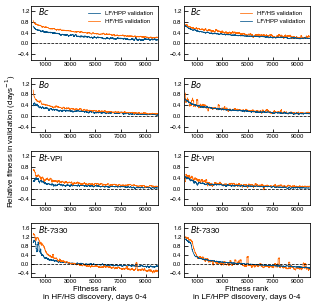

In [8]:
RANK_ORDER_FORMATS = {'BWH2': (20000, [1000, 5000, 10000, 15000, 19000], ['1000', '5000', '10000', '15000', '19000']),
                      'Bovatus': (10000, [1000, 3000, 5000, 7000, 9000], ['1000', '3000', '5000', '7000', '9000']),
                      'BtVPI': (10000, [1000, 3000, 5000, 7000, 9000], ['1000', '3000', '5000', '7000', '9000']),
                      'Bt7330': (5000, [500, 1500, 2500, 3500, 4500], ['500', '1500', '2500', '3500', '4500'])}
DIET_NAMES = {'HF':'HF/HS', 'LF':'LF/HPP', 'HLH':'HF/HS', 'LHL':'LF/HPP'}

fig = plt.figure(figsize=(5, 5))
outer = mpl.gridspec.GridSpec(nrows=7, ncols=2,
                              height_ratios=[1, 0.1, 1, 0.1, 1, 0.1, 1], figure=fig)

cg = 100 # coarse-grain


all_ax_rank = fig.add_subplot(outer[:, 0])
all_ax_rank.set_ylabel('Relative fitness in validation (days$^{-1}$)', fontsize=8, labelpad=3)
ax_methods.turn_off_ax(all_ax_rank)


HF_discovery = [6, 7, 8, 9, 10]
LF_discovery = [11, 12, 13, 15]
HF_validation = [1, 2, 3, 5]
LF_validation = [16, 18, 19]



discovery_d0, discovery_d1 = 0, 4
validation_d0, validation_d1 = 0, 4
discovery_dt = discovery_d1 - discovery_d0
validation_dt = validation_d1 - validation_d0
gene_nn = False
min_reads = 5
cutoff = 10**-6.5
sorted_indices_dict = {}

# discovery_validation_sets = [('HF/HS', [(HF_discovery, LF_validation, 4), (HF_discovery, HF_validation, 9)]),
#                              ('LF/HPP', [(LF_discovery, HF_validation, 4), (LF_discovery, LF_validation, 9)])]

HF_color = DIET_COLORS['HF']
LF_color = DIET_COLORS['LF']
discovery_validation_sets = [('HF/HS', [(HF_discovery, LF_validation, LF_color), (HF_discovery, HF_validation, HF_color)]),
                             ('LF/HPP', [(LF_discovery, HF_validation, HF_color), (LF_discovery, LF_validation, LF_color)])]

for b, bac in enumerate(['BWH2', 'Bovatus', 'BtVPI', 'Bt7330']):
    row_ids = bac_row_ids[bac]
    notWu = bac_nonwu_indices[bac]
    read_array = bac_read_arrays[bac][:, notWu]
    input_array = bac_input_arrays[bac][:, notWu]

    input_set1 = np.arange(0, input_array.shape[0], 2)
    input_set2 = np.arange(1, input_array.shape[0], 2)
    joint_set = list(input_set1) + list(input_set2)

    d0_reads = input_array[joint_set].sum(axis=0)
    d0_freqs = d0_reads / d0_reads.sum()

    n_fit = 10000
    # for c, (discovery_mice, validation_mouse) in enumerate([(HF_discovery, HF_validation), (HF_discovery, LF_validation), (LF_discovery, LF_validation), (LF_discovery, HF_validation)]):
    for j, (discovery_diet, discovery_validation_set) in enumerate(discovery_validation_sets):
        ax_rank_order = fig.add_subplot(outer[2*b, j])
        # for b, (bac, n_fit) in enumerate([('BWH2', 10000), ('Bovatus', 10000), ('BtVPI', 10000), ('Bt7330', 10000)]):
        for (discovery_mice, validation_mice, color) in discovery_validation_set:
            if 'generate discovery and validation frequencies':
                discovery_reads0, discovery_reads1 = np.copy(fl.get_read_arrays(bac, discovery_mice, discovery_d0, discovery_d1, split_day0=2))
                validation_reads0, validation_reads1 = np.copy(fl.get_read_arrays(bac, validation_mice, validation_d0, validation_d1, split_day0=1))
                # discovery_reads0 -= fl.bac_input_arrays[bac][6][fl.bac_nonwu_indices[bac]]

                discovery_D0, discovery_D1 = discovery_reads0.sum(), discovery_reads1.sum()
                discovery_freqs0, discovery_freqs1 = discovery_reads0 / discovery_D0, discovery_reads1 / discovery_D1

                validation_D0, validation_D1 = validation_reads0.sum(), validation_reads1.sum()
                validation_freqs0, validation_freqs1 = validation_reads0 /validation_D0, validation_reads1 /validation_D1

                d0_reads = fl.bac_read_arrays[bac][0][fl.bac_nonwu_indices[bac]]
                d0_freqs = d0_reads / d0_reads.sum()
                d1_reads = (discovery_reads1 + validation_reads1)

                max_freqs = np.max([discovery_freqs0, discovery_freqs1], axis=0)
                d_valid = fl.filter_lineages(discovery_reads0, discovery_reads1, min_reads=min_reads, threshold=max_freqs)
                v_valid = fl.filter_lineages(validation_reads0, validation_reads1, min_reads=min_reads, threshold=max_freqs)

                filtered_bool =  (d0_freqs > cutoff) * v_valid #* d_valid
                lineage_indices = rnd.permutation( np.arange(d0_freqs.shape[-1])[filtered_bool] )

                d_f0, d_f1 = fl.maxmin_freqs(discovery_freqs0, discovery_D0, discovery_freqs1, discovery_D1)
                v_f0, v_f1 = fl.maxmin_freqs(validation_freqs0, validation_D0, validation_freqs1, validation_D1)

            if 'generate sorted fitnesses':
                # n_fit = len(lineage_indices)
                fit_indices, sorted_fitnesses = fl.rank_barcodes(d_f0[lineage_indices], d_f1[lineage_indices], discovery_dt)
                fit_indices = lineage_indices[fit_indices]

                # n_fit = filtered_bool.sum()
                v_f0_fit, v_f1_fit = v_f0[fit_indices][:n_fit], v_f1[fit_indices][:n_fit]
                d_freqs0_fit, d_freqs1_fit = discovery_freqs0[fit_indices][:n_fit], discovery_freqs1[fit_indices][:n_fit]
                v_freqs0_fit, v_freqs1_fit = validation_freqs0[fit_indices][:n_fit], validation_freqs1[fit_indices][:n_fit]
                validation_lfcs = fl.calc_lfc_array(v_f0_fit, v_f1_fit, validation_dt)

                cg_validate_lfcs = calc_coarse_grained_lfc_array(v_freqs0_fit, validation_D0, v_freqs1_fit, validation_D1,
                                                                 validation_dt, coarse_grain=cg)
                gene_complement_f0, gene_complement_f1 = fl.calc_gene_complement_freqs(bac, fit_indices[:n_fit], validation_freqs0, validation_freqs1, nearest_neighbors=gene_nn, cutoff=cutoff)
                cg_gene_complement_lfcs = calc_coarse_grained_lfc_array(gene_complement_f0, validation_D0, gene_complement_f1, validation_D1,
                                                                        validation_dt, coarse_grain=cg)

            if 'rank order plot':
                label = DIET_NAMES[mouse2diet[validation_mice[0]]]
                ax_rank_order.plot(np.arange(cg_validate_lfcs.shape[-1])[cg//2:-cg//2],
                                    cg_validate_lfcs[cg//2:-cg//2], color=color, label=f'{label} validation')

        if 'format rank order plot':
            _, xticks, xtick_labels = RANK_ORDER_FORMATS['Bovatus']
            ax_rank_order.set_xticks(xticks)
            ax_rank_order.set_xticklabels(xtick_labels)
            ax_rank_order.set_xlim(-n_fit/100, n_fit)
            ax_rank_order.set_ylim(-0.6, 1.4)
            y_ticks = [-0.4, 0, 0.4, 0.8, 1.2]
            if bac == 'Bt7330':
                ax_rank_order.set_ylim(-0.6, 1.8)
                y_ticks = [-0.4, 0, 0.4, 0.8, 1.2, 1.6]
            ax_rank_order.set_yticks(y_ticks, fontsize=40)
            ax_rank_order.axhline(0, color='black', linestyle='dashed')
            ax_rank_order.text(0.05, 0.82, f'{BAC_FORMAL_NAMES[bac]}', transform=ax_rank_order.transAxes)
            # ax_rank_order.text(-0.05, 1.05, panel_indices[bac][0], fontsize=8, transform=ax_rank_order.transAxes)
            if b == 3:
                disco_diet = DIET_NAMES[mouse2diet[discovery_mice[0]]]
                ax_rank_order.set_xlabel(f'Fitness rank\nin {disco_diet} discovery, days 0-4', fontsize=8, labelpad=2)
            if bac == 'BWH2':
                ax_rank_order.legend(frameon=False)

fig.savefig(f'{biorxiv}/SI_04_rank_order_switch_diets.pdf')
